<a href="https://colab.research.google.com/github/arjundussa65/Thesis-2020/blob/master/XLNET_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers

     |████████████████████████████████| 778kB 4.3MB/s 
     |████████████████████████████████| 890kB 13.6MB/s 
     |████████████████████████████████| 3.0MB 13.5MB/s 
     |████████████████████████████████| 1.1MB 47.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=75bf20791683a85eccb9e074d10f9cf7953554a26a9e263639e58f3f6bd7c6b8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#mount google drive for colab usage
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# importing the necessary libraries 


import torch.nn as nn

import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
df=pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/covid_labelled.csv", encoding='utf-8',usecols=['Text','Num_Sentiment'])

In [ ]:
df.head()

,Text,Num_Sentiment
0,stat news speed is critical as spreads in offi...,-1
1,the first australian has now passed away from ...,0
2,new york magazine new coronavirus cases confir...,-1
3,still not at friday lows but we moving let s s...,-1
4,things look bleak for oil barrel seems an easy...,0


In [ ]:
df.loc[:,'sentiment'] = df.Num_Sentiment.map({-1:'Negative',0:'Neutral',1:'Positive'})

In [ ]:
df.head()

,Text,Num_Sentiment,sentiment
0,stat news speed is critical as spreads in offi...,-1,Negative
1,the first australian has now passed away from ...,0,Neutral
2,new york magazine new coronavirus cases confir...,-1,Negative
3,still not at friday lows but we moving let s s...,-1,Negative
4,things look bleak for oil barrel seems an easy...,0,Neutral


In [ ]:
one_hot = pd.get_dummies(df["sentiment"])
df.drop(['Num_Sentiment','sentiment'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,Text,Negative,Neutral,Positive
0,stat news speed is critical as spreads in offi...,1,0,0
1,the first australian has now passed away from ...,0,1,0
2,new york magazine new coronavirus cases confir...,1,0,0
3,still not at friday lows but we moving let s s...,1,0,0
4,things look bleak for oil barrel seems an easy...,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split

train,test =\
    train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
train_text_list = train["Text"].values
test_text_list = test["Text"].values

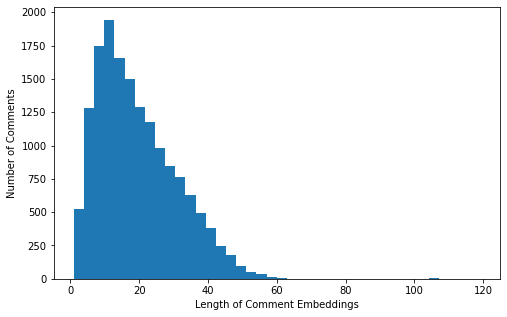

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

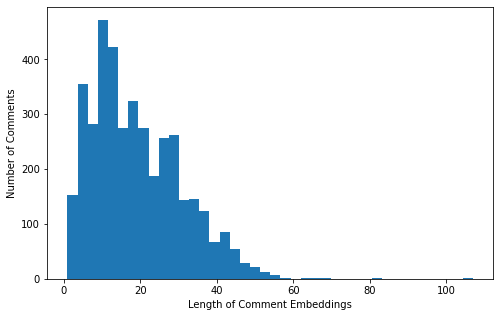

In [ ]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=90)
train_input_ids

array([[   24, 12683,   101, ...,     0,     0,     0],
       [   25,    24,   185, ...,     0,     0,     0],
       [   17,    98,   751, ...,     0,     0,     0],
       ...,
       [   27,    48,  1394, ...,     0,     0,     0],
       [  116,  8458,   938, ...,     0,     0,     0],
       [ 5216,   830,  7791, ...,     0,     0,     0]])

In [ ]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=90)
test_input_ids

array([[   18,    27,  1411, ...,     0,     0,     0],
       [10828,  1997,   618, ...,     0,     0,     0],
       [  932,  1002,  1436, ...,     0,     0,     0],
       ...,
       [   18,  9989,   894, ...,     0,     0,     0],
       [   17,  1315,   986, ...,     0,     0,     0],
       [   18,   513,  6526, ...,     0,     0,     0]])

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)


In [ ]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)


In [ ]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
train.head()

,Text,Negative,Neutral,Positive,features,masks
7852,alexa find me a new house mate,0,1,0,"[24, 12683, 101, 278, 110, 24, 109, 480, 11680...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
19487,in a world ill prepared for a potentially life...,0,0,1,"[25, 24, 185, 4195, 2106, 28, 24, 5375, 235, 7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
11752,mta workers clean a subway car in new york city,0,0,1,"[17, 98, 751, 1042, 2146, 24, 12062, 398, 25, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
13761,free ground shipping available with our double...,0,0,1,"[325, 881, 3967, 387, 33, 120, 1620, 6211, 730...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
18256,by now you have likely heard of the being cove...,0,1,0,"[37, 145, 44, 47, 774, 1133, 20, 18, 163, 1972...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
test.head()

,Text,Negative,Neutral,Positive,features,masks
16711,the is wrong and are an infringement on our fu...,1,0,0,"[18, 27, 1411, 21, 41, 48, 18885, 31, 120, 464...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4982,oh baby let s play subscribe now,0,0,1,"[10828, 1997, 618, 17, 23, 354, 10518, 145, 4,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
18825,anti stock levels are do not wait until the la...,1,0,0,"[932, 1002, 1436, 41, 112, 50, 2065, 259, 18, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
14426,im thinking and will be good tomorrow sector b...,0,0,1,"[7693, 1720, 21, 53, 39, 195, 4305, 1967, 2008...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
10575,about of workers laid off in the united states...,0,0,1,"[75, 20, 1042, 3514, 177, 25, 18, 9114, 1035, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
# train valid split
train, valid = train_test_split(train, test_size=0.25, random_state=42)

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = ['Negative','Neutral','Positive']
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    # Instantiate an one-layer feed-forward classifier
    self.classifier = torch.nn.Sequential(torch.nn.Linear(768, 50),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(0.5),
                    torch.nn.Linear(50,num_labels))

   # torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
  #  mean_last_hidden_state = self.activation(mean_last_hidden_state)
 #   mean_last_hidden_state = self.dropout(mean_last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
model.cuda()

XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), ep

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
num_epochs=2

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_nosampling.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.01959043419174505
Valid loss: 0.01808221676198559


Epoch:  50%|█████     | 1/2 [04:40<04:40, 280.86s/it]

Saving model at epoch 0 with validation loss of 0.01808221676198559


Train loss: 0.013821310671747102
Valid loss: 0.009021018034308523


Epoch: 100%|██████████| 2/2 [09:29<00:00, 284.85s/it]

Saving model at epoch 1 with validation loss of 0.009021018034308523




Text(0.5, 1.0, 'Loss vs Number of Epochs')

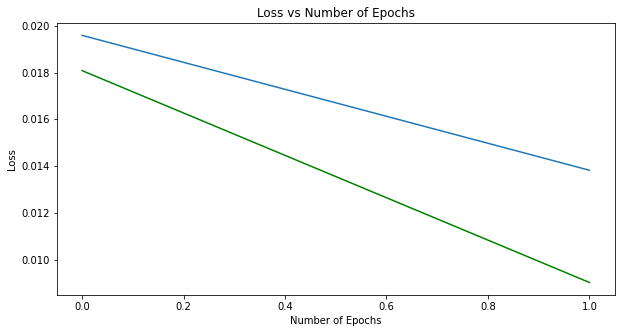

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")
ax.set_

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_nosampling.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[0.74725372, 0.16965562, 0.09121708],
       [0.26664841, 0.30856171, 0.47826087],
       [0.75028366, 0.1688873 , 0.09029555],
       ...,
       [0.7557649 , 0.16615003, 0.08710352],
       [0.01598807, 0.95233232, 0.0351059 ],
       [0.75769597, 0.16563292, 0.08631097]])

In [ ]:
a=np.round(pred_probs)

In [ ]:
from sklearn.metrics import accuracy_score
y_test=test.iloc[:,1:4].values
accuracy_score(y_test,a)

0.7904569553143146

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
y_pred=np.round(pred_probs)
print(classification_report(y_test, a, target_names=['Negative', 'Neutral', 'Positive']))


Classification Report

              precision    recall  f1-score   support

    Negative       0.65      0.85      0.74       721
     Neutral       0.93      0.70      0.80      1715
    Positive       0.86      0.86      0.86      1525

   micro avg       0.83      0.79      0.81      3961
   macro avg       0.81      0.81      0.80      3961
weighted avg       0.85      0.79      0.81      3961
 samples avg       0.79      0.79      0.79      3961



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

[[ 662   15   44]
 [ 340 1200  175]
 [ 133   77 1315]]


In [ ]:
import torch
from torch.autograd.function import InplaceFunction

class Mixout(InplaceFunction):
    # target: a weight tensor mixes with a input tensor
    # A forward method returns 
    # [(1 - Bernoulli(1 - p) mask) * target + (Bernoulli(1 - p) mask) * input - p * target]/(1 - p) 
    # where p is a mix probability of mixout.
    # A backward returns the gradient of the forward method.
    # Dropout is equivalent to the case of target=None. 
    # I modified the code of dropout in PyTorch. 
    @staticmethod
    def _make_noise(input):
        return input.new().resize_as_(input)

    @classmethod
    def forward(cls, ctx, input, target=None, p=0.0, training=False, inplace=False):
        if p < 0 or p > 1:
            raise ValueError("A mix probability of mixout has to be between 0 and 1,"
                             " but got {}".format(p))
        if target is not None and input.size() != target.size():
            raise ValueError("A target tensor size must match with a input tensor size {},"
                             " but got {}". format(input.size(), target.size()))
        ctx.p = p    
        ctx.training = training
        
        if target is None:
            target = cls._make_noise(input)
            target.fill_(0)
        target = target.to(input.device)

        if inplace:
            ctx.mark_dirty(input)
            output = input
        else:
            output = input.clone()
        
        if ctx.p == 0 or not ctx.training:
            return output
        
        ctx.noise = cls._make_noise(input)
        if len(ctx.noise.size()) == 1:
            ctx.noise.bernoulli_(1 - ctx.p)
        else:
            ctx.noise[0].bernoulli_(1 - ctx.p)
            ctx.noise = ctx.noise[0].repeat(input.size()[0], *([1] * (len(input.size())-1)))
        ctx.noise.expand_as(input)
        
        if ctx.p == 1:
            output = target.clone()
        else:
            output = ((1 - ctx.noise) * target + ctx.noise * output - ctx.p * target) / (1 - ctx.p)
        return output
        
    @staticmethod
    def backward(ctx, grad_output):
        if ctx.p > 0 and ctx.training:
            return grad_output * ctx.noise, None, None, None, None
        else:
            return grad_output, None, None, None, None

def mixout(input, target=None, p=0.0, training=False, inplace=False):
    return Mixout.apply(input, target, p, training, inplace)

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn import Parameter
!ls '/content/gdrive/My Drive/Colab Notebooks/mixout.py'
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
from mixout import mixout

class MixLinear(torch.nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']
    # If target is None, nn.Sequential(nn.Linear(m, n), MixLinear(m', n', p)) 
    # is equivalent to nn.Sequential(nn.Linear(m, n), nn.Dropout(p), nn.Linear(m', n')).
    # If you want to change a dropout layer to a mixout layer, 
    # you should replace nn.Linear right after nn.Dropout(p) with Mixout(p) 
    def __init__(self, in_features, out_features, bias=True, target=None, p=0.0):
        super(MixLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        self.target = target
        self.p = p
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
            
    def forward(self, input):
        return F.linear(input, mixout(self.weight, self.target, 
                                      self.p, self.training), self.bias)

    def extra_repr(self):
        type = 'drop' if self.target is None else 'mix' 
        return '{}={}, in_features={}, out_features={}, bias={}'.format(type+"out", self.p,
            self.in_features, self.out_features, self.bias is not None)

'/content/gdrive/My Drive/Colab Notebooks/mixout.py'


In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    # Instantiate an one-layer feed-forward classifier
    self.classifier= nn.Linear(768, num_labels)    

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
 #   mean_last_hidden_state = self.activation(mean_last_hidden_state)
 #   mean_last_hidden_state = self.dropout(mean_last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
 #   logits = self.classifier1(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
for name, module in model.named_modules():
    if name in ['dropout'] and isinstance(module, nn.Dropout):
        setattr(model, name, nn.Dropout(0))
    if name in ['classifier'] and isinstance(module, nn.Linear):
        target_state_dict = module.state_dict()
        bias = True if module.bias is not None else False
        new_module = MixLinear(module.in_features, module.out_features, 
                               bias, target_state_dict['weight'], 0.5)
        new_module.load_state_dict(target_state_dict)
        setattr(model, name, new_module)
model.cuda()

XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), ep

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
num_epochs=2

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_nosampling_mix.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.0155933018403209
Valid loss: 0.009281312610894795


Epoch:  50%|█████     | 1/2 [04:42<04:42, 282.82s/it]

Saving model at epoch 0 with validation loss of 0.009281312610894795


Train loss: 0.007624281159912651
Valid loss: 0.006483002139052728


Epoch: 100%|██████████| 2/2 [09:33<00:00, 286.55s/it]

Saving model at epoch 1 with validation loss of 0.006483002139052728




Text(0.5, 1.0, 'Loss vs Number of Epochs')

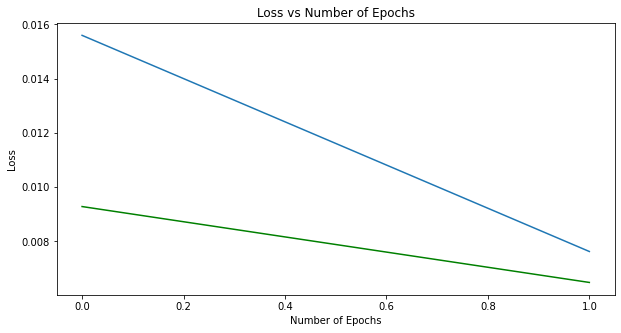

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "gdrive/My Drive/Colab Notebooks/xlnet_tweet_nosampling_mix.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

array([[9.48528767e-01, 2.93025915e-02, 8.16656277e-03],
       [9.39460879e-04, 3.42355622e-03, 9.94336069e-01],
       [9.65040088e-01, 1.95545480e-02, 6.78217085e-03],
       ...,
       [9.40235496e-01, 3.97831686e-02, 8.53275321e-03],
       [3.76926502e-03, 9.92687583e-01, 3.96824395e-03],
       [9.76056814e-01, 1.15038911e-02, 2.03275261e-03]])

In [ ]:
s=np.round(pred_probs)

In [ ]:
s

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [ ]:
from sklearn.metrics import accuracy_score
y_test=test.iloc[:,1:4].values
accuracy_score(y_test,s)

0.849028023226458

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
y_pred=np.round(pred_probs)
print(classification_report(y_test, s, target_names=['Negative', 'Neutral', 'Positive']))


Classification Report

              precision    recall  f1-score   support

    Negative       0.77      0.86      0.81       721
     Neutral       0.93      0.81      0.87      1715
    Positive       0.90      0.89      0.90      1525

   micro avg       0.89      0.85      0.87      3961
   macro avg       0.87      0.85      0.86      3961
weighted avg       0.89      0.85      0.87      3961
 samples avg       0.85      0.85      0.85      3961



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

[[ 665   30   26]
 [ 205 1386  124]
 [  93   71 1361]]
